# TAN — Next Level (CMI, Kruskal, BDeu, CV, visualization)

This notebook implements an upgraded Tree-Augmented Naive Bayes (TAN) for heart disease.
Enhancements: conditional mutual information (CMI), Kruskal-based Chow–Liu tree, BDeu CPTs,
Naive Bayes baseline, 5-fold CV, and network visualization for interpretation.


In [1]:
# Imports & settings
import numpy as np, pandas as pd, math, random, time
from itertools import product, combinations
from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(42)
random.seed(42)


### Load and inspect dataset
Load the UCI/Kaggle heart dataset. Keep key clinical columns and convert the target
to 'yes'/'no'. If your file is named differently change the filename below.


In [4]:
df = pd.read_csv("heart.csv")

# Rename to classical heart-disease feature names
df = df.rename(columns={
    'Age': 'age',
    'Sex': 'sex',
    'ChestPainType': 'cp',
    'RestingBP': 'trestbps',
    'Cholesterol': 'chol',
    'FastingBS': 'fbs',
    'RestingECG': 'restecg',
    'MaxHR': 'thalach',
    'ExerciseAngina': 'exang',
    'Oldpeak': 'oldpeak',
    'ST_Slope': 'slope',
    'HeartDisease': 'target'
})

# Convert target to yes/no
df['target'] = df['target'].map({0:'no', 1:'yes'})

print(df.head())
print(df.columns)


   age sex   cp  trestbps  chol  fbs restecg  thalach exang  oldpeak slope  \
0   40   M  ATA       140   289    0  Normal      172     N      0.0    Up   
1   49   F  NAP       160   180    0  Normal      156     N      1.0  Flat   
2   37   M  ATA       130   283    0      ST       98     N      0.0    Up   
3   48   F  ASY       138   214    0  Normal      108     Y      1.5  Flat   
4   54   M  NAP       150   195    0  Normal      122     N      0.0    Up   

  target  
0     no  
1    yes  
2     no  
3    yes  
4     no  
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'target'],
      dtype='object')


In [5]:
cont = ['age','trestbps','chol','thalach','oldpeak']
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df[cont] = disc.fit_transform(df[cont]).astype(int)
# convert to str categories
for c in df.columns:
    df[c] = df[c].astype(str)
df.nunique()


c:\Users\madhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


age         3
sex         2
cp          4
trestbps    3
chol        3
fbs         2
restecg     3
thalach     3
exang       2
oldpeak     3
slope       3
target      2
dtype: int64

### Train-test split
We reserve 25% as test set. Training set is for learning TAN and NB, test set for final evaluation.


In [6]:
train_df, test_df = train_test_split(df, test_size=0.25, stratify=df['target'], random_state=42)
features = [c for c in df.columns if c!='target']
print(train_df.shape, test_df.shape)


(688, 12) (230, 12)


### Conditional Mutual Information (CMI)
CMI I(X;Y | C) measures dependency between features X and Y conditioned on class C.
We implement it by summing MI(X;Y) within each class weighted by P(class).


In [8]:
def cond_mutual_info(df, X, Y, C):
    # I(X;Y | C) = sum_c P(c) * I(X;Y | C=c)
    pC = df[C].value_counts(normalize=True).to_dict()
    total = 0.0
    for c_val, p_c in pC.items():
        sub = df[df[C]==c_val]
        if len(sub) < 5:
            continue
        joint = pd.crosstab(sub[X], sub[Y], normalize=True)
        px = sub[X].value_counts(normalize=True)
        py = sub[Y].value_counts(normalize=True)
        mi = 0.0
        for x in joint.index:
            for y in joint.columns:
                pxy = joint.loc[x,y]
                if pxy > 0:
                    mi += pxy * math.log(pxy / (px[x]*py[y]))
        total += p_c * mi
    return total

# quick sanity
print("CMI example (cp, trestbps | target):", cond_mutual_info(train_df, 'cp','trestbps','target'))


CMI example (cp, trestbps | target): 0.00652791379827823


### Chow–Liu via Kruskal + Union-Find
We compute CMI for every feature pair conditioned on class, sort edges by weight,
and run Kruskal's algorithm (union-find) to form the maximum spanning tree.


In [9]:
# union-find
class UnionFind:
    def __init__(self, n): self.parent=list(range(n)); self.rank=[0]*n
    def find(self,a):
        while self.parent[a]!=a:
            self.parent[a]=self.parent[self.parent[a]]
            a=self.parent[a]
        return a
    def union(self,a,b):
        ra,rb=self.find(a),self.find(b)
        if ra==rb: return False
        if self.rank[ra]<self.rank[rb]: self.parent[ra]=rb
        else:
            self.parent[rb]=ra
            if self.rank[ra]==self.rank[rb]: self.rank[ra]+=1
        return True

def chow_liu_kruskal(df, features, class_var):
    n=len(features)
    edges=[]
    for i in range(n):
        for j in range(i+1,n):
            w=cond_mutual_info(df, features[i], features[j], class_var)
            edges.append((i,j,w))
    edges.sort(key=lambda x:-x[2])
    uf=UnionFind(n)
    tree=[]
    for i,j,w in edges:
        if uf.union(i,j):
            tree.append((i,j,w))
        if len(tree)==n-1: break
    return tree

tree_edges = chow_liu_kruskal(train_df, features, 'target')
# map to feature names for easy use
tree_pairs = [(features[i], features[j], w) for i,j,w in tree_edges]
print("Tree edges (feature names):")
for a,b,w in tree_pairs: print(a,"--",b, f"(CMI={w:.4f})")


Tree edges (feature names):
oldpeak -- slope (CMI=0.0674)
age -- trestbps (CMI=0.0385)
thalach -- exang (CMI=0.0368)
age -- thalach (CMI=0.0367)
exang -- slope (CMI=0.0358)
age -- restecg (CMI=0.0307)
cp -- oldpeak (CMI=0.0305)
chol -- oldpeak (CMI=0.0293)
chol -- fbs (CMI=0.0232)
sex -- chol (CMI=0.0110)


### Build TAN parent sets
In TAN every feature has the class as a parent (like NB) plus one extra parent from the tree.
We orient the undirected tree arbitrarily from a chosen root.


In [10]:
def build_tan_parents(features, tree_pairs, class_var):
    # build adjacency undirected
    idx = {f:i for i,f in enumerate(features)}
    adj={i:set() for i in range(len(features))}
    for a,b,w in tree_pairs:
        i,j = idx[a], idx[b]; adj[i].add(j); adj[j].add(i)
    parents = {f:[class_var] for f in features}
    root = 0
    visited={root}
    stack=[root]
    while stack:
        u=stack.pop()
        for v in adj[u]:
            if v not in visited:
                parents[features[v]].append(features[u])
                visited.add(v); stack.append(v)
    return parents

parents = build_tan_parents(features, tree_pairs, 'target')
for i,f in enumerate(features[:8]): print(f,"parents->",parents[f])


age parents-> ['target']
sex parents-> ['target', 'chol']
cp parents-> ['target', 'oldpeak']
trestbps parents-> ['target', 'age']
chol parents-> ['target', 'oldpeak']
fbs parents-> ['target', 'chol']
restecg parents-> ['target', 'age']
thalach parents-> ['target', 'age']


### BDeu CPT estimation (Dirichlet prior)
We implement BDeu parameter estimation with an equivalent sample size (ESS).
This stabilizes CPTs when some parent configurations are rare.


In [11]:
# precompute domains
domains = {c: sorted(train_df[c].unique()) for c in train_df.columns}

def learn_cpts_bdeu(df, features, class_var, parents, ess=5.0):
    cpts = {}
    # class prior with Dirichlet uniform
    K = len(domains[class_var])
    alpha0 = ess / K
    class_counts = df[class_var].value_counts().to_dict()
    N = len(df)
    cpts[class_var] = {v: (class_counts.get(v,0)+alpha0)/(N+ess) for v in domains[class_var]}
    # features
    for f in features:
        par_list = parents[f]
        par_domains = [domains[p] for p in par_list]
        table={}
        # iterate combos
        for combo in product(*par_domains):
            # subset for this parent combo
            cond = np.ones(len(df), dtype=bool)
            for p,val in zip(par_list,combo):
                cond &= (df[p].values==val)
            sub = df[cond]
            counts = sub[f].value_counts().to_dict()
            total = len(sub)
            k = len(domains[f])
            # distribute ESS evenly across parent-child states
            alpha = ess / (k * max(1, np.prod([len(domains[p]) for p in par_list]))) if par_list else ess/k
            probs={}
            for val in domains[f]:
                probs[val] = (counts.get(val,0)+alpha)/(total + k*alpha) if (total + k*alpha)>0 else 1.0/k
            table[combo]=probs
        cpts[f]=table
    return cpts

cpts_bdeu = learn_cpts_bdeu(train_df, features, 'target', parents, ess=5.0)
# show one small CPT
f_example = features[0]
print("Example CPT for", f_example)
list(cpts_bdeu[f_example].items())[:3]


Example CPT for age


[(('no',),
  {'0': np.float64(0.4194938072159397),
   '1': np.float64(0.3193322563274098),
   '2': np.float64(0.2611739364566505)}),
 (('yes',),
  {'0': np.float64(0.20556279878313774),
   '1': np.float64(0.3202955236853542),
   '2': np.float64(0.47414167753150804)})]

### TAN prediction and evaluation helpers
We compute P(target | x) using class prior and CPTs, then evaluate with standard metrics.


In [12]:
def predict_prob_tan(cpts, parents, row, class_var='target'):
    # returns probability of 'yes'
    classes = domains[class_var]
    scores = {c: cpts[class_var].get(c,1e-9) for c in classes}
    for c in classes:
        for f in features:
            par_vals = tuple([ (c if p==class_var else row[p]) for p in parents[f] ])
            probs = cpts[f].get(par_vals, None)
            if probs is None:
                p = 1.0/len(domains[f])
            else:
                p = probs.get(row[f], 1e-9)
            scores[c] *= p
    ssum = sum(scores.values())
    for k in scores: scores[k] /= (ssum if ssum>0 else 1.0)
    return scores['yes']

def evaluate_binary(y_true, y_prob, thresh=0.5):
    y_pred = ['yes' if p>=thresh else 'no' for p in y_prob]
    print("Accuracy", accuracy_score(y_true,y_pred))
    print("Precision", precision_score(y_true,y_pred,pos_label='yes'))
    print("Recall", recall_score(y_true,y_pred,pos_label='yes'))
    print("F1", f1_score(y_true,y_pred,pos_label='yes'))
    cm = confusion_matrix(y_true,y_pred, labels=['no','yes'])
    print("Confusion:\n", cm)


### Evaluate TAN on test set (BDeu CPTs)
We predict probabilities for test instances and report metrics.


In [13]:
y_true = []
y_prob = []
for _, r in test_df.iterrows():
    y_true.append(r['target'])
    y_prob.append(predict_prob_tan(cpts_bdeu, parents, r, 'target'))
evaluate_binary(y_true, y_prob)


Accuracy 0.8739130434782608
Precision 0.9152542372881356
Recall 0.8503937007874016
F1 0.8816326530612245
Confusion:
 [[ 93  10]
 [ 19 108]]


### Naive Bayes baseline (BDeu or MLE)
We create a NB baseline (class → features only) using BDeu-like smoothing (dirichlet-like).
This lets us quantify the improvement TAN gives by modeling dependencies.


In [14]:
# NB parents: only class
nb_parents = {f:['target'] for f in features}
cpts_nb = learn_cpts_bdeu(train_df, features, 'target', nb_parents, ess=5.0)

# evaluate NB
y_prob_nb = [predict_prob_tan(cpts_nb, nb_parents, r, 'target') for _,r in test_df.iterrows()]
print("Naive Bayes baseline:")
evaluate_binary([r['target'] for _,r in test_df.iterrows()], y_prob_nb)


Naive Bayes baseline:
Accuracy 0.8869565217391304
Precision 0.904
Recall 0.889763779527559
F1 0.8968253968253969
Confusion:
 [[ 91  12]
 [ 14 113]]


### 5-fold cross-validation (TAN vs NB): AUC comparison
We perform 5-fold CV to get robust AUC estimates for TAN and NB and report mean AUCs.
This shows model stability.


In [15]:
def cv_auc_compare(df, features, class_var='target', folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    tan_aucs=[]
    nb_aucs=[]
    X=df
    y=df[class_var]
    for train_idx, val_idx in skf.split(X, y):
        tr = X.iloc[train_idx]; va = X.iloc[val_idx]
        tree = chow_liu_kruskal(tr, features, class_var)
        parents_fold = build_tan_parents(features, [(features[i],features[j],w) for i,j,w in tree], class_var)
        cpts_t = learn_cpts_bdeu(tr, features, class_var, parents_fold, ess=5.0)
        cpts_n = learn_cpts_bdeu(tr, features, class_var, {f:['target'] for f in features}, ess=5.0)
        probs_t = [predict_prob_tan(cpts_t, parents_fold, r, class_var) for _,r in va.iterrows()]
        probs_n = [predict_prob_tan(cpts_n, {f:['target'] for f in features}, r, class_var) for _,r in va.iterrows()]
        tan_aucs.append(roc_auc_score([1 if x=='yes' else 0 for x in va[class_var]], probs_t))
        nb_aucs.append(roc_auc_score([1 if x=='yes' else 0 for x in va[class_var]], probs_n))
    return tan_aucs, nb_aucs

print("Running 5-fold CV (may take a short while)...")
tan_aucs, nb_aucs = cv_auc_compare(train_df, features, 'target', folds=5)
print("TAN AUCs:", np.round(tan_aucs,3), "mean", np.mean(tan_aucs))
print("NB AUCs:", np.round(nb_aucs,3), "mean", np.mean(nb_aucs))


Running 5-fold CV (may take a short while)...
TAN AUCs: [0.954 0.91  0.909 0.895 0.932] mean 0.9199054511549294
NB AUCs: [0.938 0.904 0.91  0.907 0.912] mean 0.9140657322721253


### Visualize the TAN tree
We plot the feature tree (one parent link per feature) using networkx for interpretation.
Edges are annotated with their CMI weights.


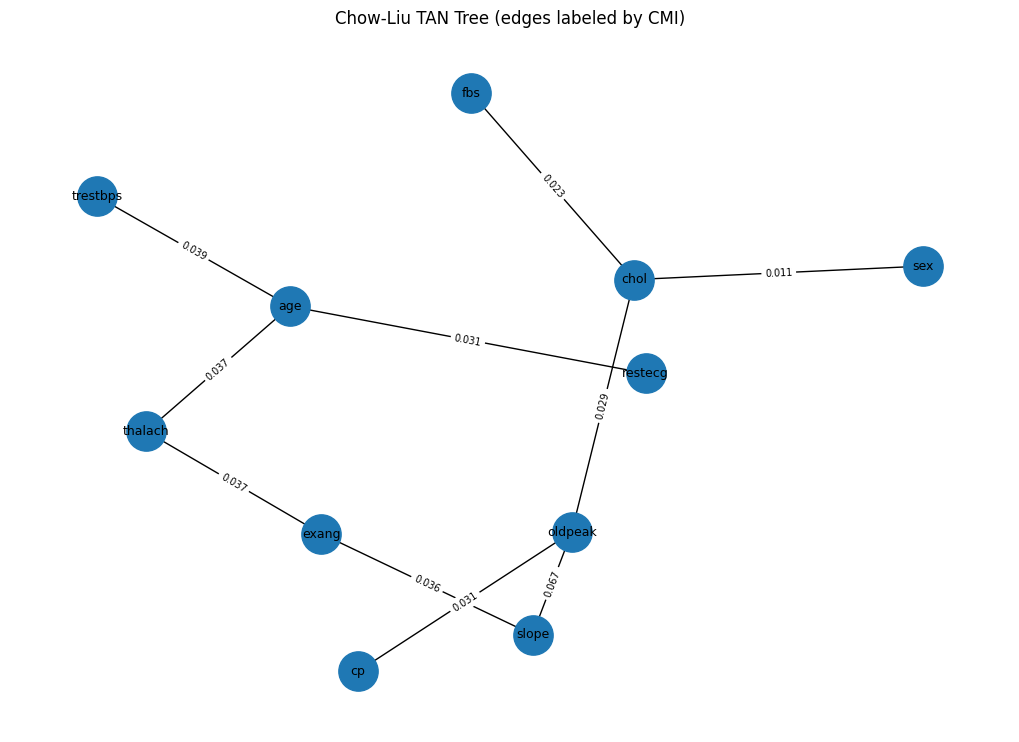

In [16]:
# build nx graph
G = nx.Graph()
G.add_nodes_from(features)
for a,b,w in tree_pairs:
    G.add_edge(a,b,weight=w)
plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, font_size=9)
edge_labels = {(u,v): f"{d['weight']:.3f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, font_size=7)
plt.title("Chow-Liu TAN Tree (edges labeled by CMI)")
plt.show()
